# Find Path Descriptors using Z space of Autoencoder

Autoencoder are good at:
- **dimensionality reduction** for data visualization
- **data denoising** for robust feature learning

Dimensions of Input space= n x 100 x 3
Dimensions of Latent space (z-space)= z

# Enhance reproducability of results

In [1]:
#%env PYTHONHASHSEED=0 
#%env CUDA_VISIBLE_DEVICES=""

In [2]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
def resetRNG(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.set_random_seed(seed_value)

# Import .npz Database containing 5SS mechanisms and cplr paths

In [4]:
# Import data offline
import os
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','norm_database5SS.npz')
db = np.load(db_path)

In [5]:
# Import data on Google CoLab
#from google.colab import files
#uploaded = files.upload()
#db = np.load('norm_database5SS.npz')

In [6]:
print(db.files)
cplr=db['cplrData']
mech=db['mechData']

print(cplr.shape)
print(mech.shape)

['cplrData', 'mechData']
(1453, 100, 3)
(1453, 11, 3)


# Splitting the database in Train/Test dataset

In [7]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=1)

# Functions to TRAIN an Autoencoder

In [8]:
from keras.layers import Input, Dense, Flatten, Reshape, SeparableConv1D, concatenate
from keras.models import Model
from keras.layers import LeakyReLU
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras import initializers
import keras

In [9]:
# Train same model architecture multiple times since the training process is stochastic

def AE_analysis(AE_model, iterations, x_train, x_test, filename='model'):
    val_loss_list=[]
    best_val_loss=np.inf;
    for i in range(iterations):
        print('Model no. '+str(i+1))
        AE, E = AE_model()
        val_loss, train_data=train_AE(AE, E, x_train, x_test)
        val_loss_list.append(val_loss)
        if best_val_loss>val_loss:
            best_AE=AE
            best_E=E
            best_train_data=train_data
            best_val_loss=val_loss
    
    # PRINT MEAN, VARIANCE and BEST MODEL METRICS
    print(val_loss_list)
    print('Average Validation Loss: '+str(np.mean(val_loss_list)))
    
    # SAVE BEST MODEL
    AEfilename='AE_'+filename+'_val_loss_'+str(best_val_loss)+'.h5'
    AEfilepath=os.path.join('models',AEfilename)
    best_AE.save(AEfilepath)
    
    return best_AE, best_E, best_train_data

In [10]:
def train_AE(autoencoder, encoder, x_train, x_test, epochs=500):
    # TRAINING PHASE
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',
                                  restore_best_weights=True)
    autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=128, 
                                      shuffle=False, validation_data=(x_test, x_test), 
                                      verbose=0, callbacks=[earlyStopping])
    
    # TRAINING DATA
    val_loss = autoencoder_train.history['val_loss']
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    return f_val_loss, autoencoder_train

# Functions to VISUALIZE an Autoencoder

In [11]:
def visualize_AE(AE, train_data, x_test):
    # VISUALIZING TRAINING CURVES
    visualize_train_curves(train_data)
    
    # VISUALIZE RECONSTRUCTED CURVES
    reconst_curve = AE.predict(x_test)
    visualize_reconstructed_CplrCurves(x_test, reconst_curve, 20)

    
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure(figsize=(14, 7))
    plt.plot(epochsRange, loss, 'r', label='Training loss')
    plt.plot(epochsRange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def visualize_reconstructed_CplrCurves(x_test, reconst_curve, n=10, b_spline=False):
    fig= plt.figure(figsize=(3*4, 3*n))
    fig.suptitle('Isometric (3D), Top (X-Y Plane), Front (X-Z Plane) and Right (Y-Z Plane) View', fontsize=14, fontweight='bold')
    for i in range(n):
        # Isometric View
        ax = plt.subplot(n, 4, 4*i+1, projection='3d')
        if b_spline:
            reconst_curve[i]=b_spline_interpolation(reconst_curve[i], 100)
        plotPath3D(reconst_curve[i], ax, 2,'r' )
        plotPath3D(x_test[i], ax, 2)
        
        #x-y, x-z, y-z plane view
        xy_recon=reconst_curve[i,:,0:2]
        xy_orig=x_test[i,:,0:2]
        xz_recon=np.concatenate(([reconst_curve[i,:,0]], [reconst_curve[i,:,2]]),axis=0).T
        xz_orig=np.concatenate(([x_test[i,:,0]], [x_test[i,:,2]]),axis=0).T
        yz_recon=reconst_curve[i,:,1:3]
        yz_orig=x_test[i,:,1:3]
        
        # Top View
        ax = plt.subplot(n, 4, 4*i+2)
        plotPath(xy_recon, ax, 2,'r' )
        plotPath(xy_orig, ax, 2)
        
        # Front View
        ax = plt.subplot(n, 4, 4*i+3)
        plotPath(xz_recon, ax, 2,'r' )
        plotPath(xz_orig, ax, 2)
        
        # Right View
        ax = plt.subplot(n, 4, 4*i+4)
        plotPath(yz_recon, ax, 2,'r' )
        plotPath(yz_orig, ax, 2)
        
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [12]:
# Plotting Functions

%matplotlib inline
#%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import interpolate


def plotPath3D(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    
def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    ax.plot(xline, yline, color)
    ax.set(xlim=(-limit, limit), ylim=(-limit, limit))

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))


def b_spline_interpolation(inp_pts, out_n):
    # Fit cubic B-spline to the points
    xp=inp_pts[i,:,0]
    yp=inp_pts[i,:,1]
    zp=inp_pts[i,:,2]
        
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]
    
    tck, u =interpolate.splprep([xp,yp,zp],s=1)
    num_pts=out_n
    u_fine = np.linspace(0,1,num_pts)
    x_f, y_f, z_f = interpolate.splev(u_fine, tck)
    Path_f = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_f

# Tweaking Regularization Hyperparameter

Regularizing the bottleneck layer enforces the output to be better behaved i.e. the output range is smaller. This leads to 'reduced activity' and the model generalizes better and avoids overfitting. However, the validation loss for each model increases by increasing regularization. Thus, optimal regularization parameter in emperically explored.

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00124: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00215: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00146: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00119: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00104: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00143: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00166: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00158: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00152: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00128: early stopping
[0.05, 0.0448, 0.0487, 0.0469, 0.0539, 0.0496, 0.

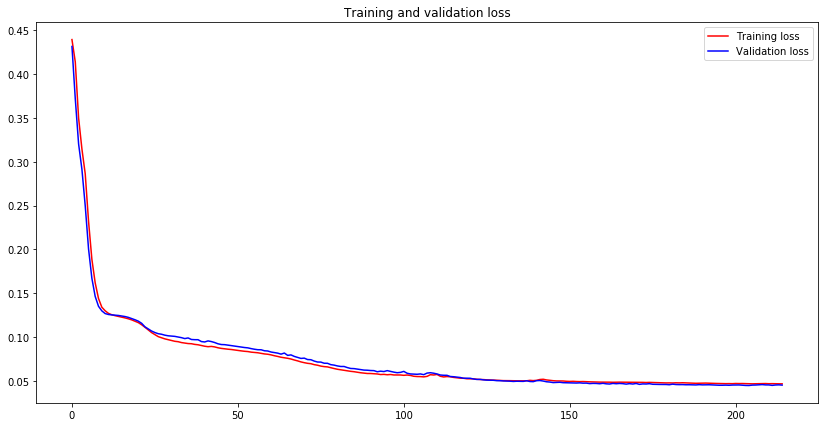

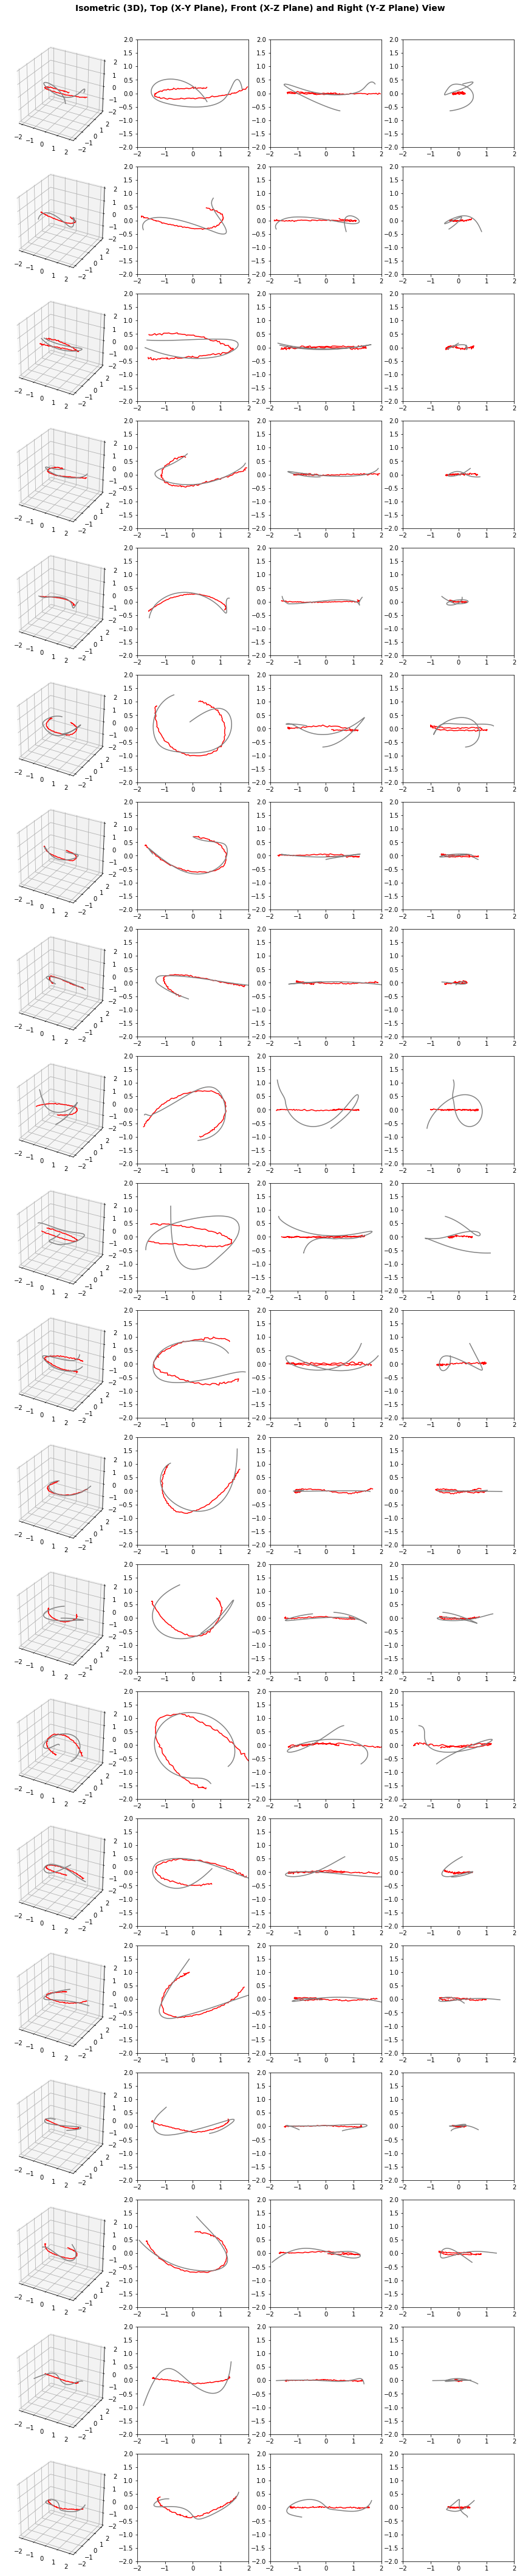

In [30]:
def autoEncoderRZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(20, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(3, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(20, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ3, 10, x_train, x_test, filename='RZ3')
visualize_AE(AE, train_data, x_test)

In [15]:
import os
import numpy as np
from keras.models import Model, load_model

# Load Autoencoder model with Z=3
filename='AE_Z3_val_loss_0.0435.h5'
path=os.path.join('models',filename)
AE_Z3 = load_model(path)
E_Z3 = Model(AE_Z3.input, AE_Z3.layers[6].output)
E_Z3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_342 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_343 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_344 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_345 (Dense)            (None, 3)                 33        
Total para

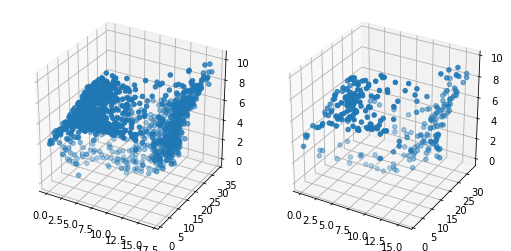

Mean train activation: 10.117656
Mean train activation: 10.015968


In [20]:
z_param_train = E_Z3.predict(x_train)
z_param_test = E_Z3.predict(x_test)
#print(z_param)


fig = plt.figure(figsize=1.8/2*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(z_param_train[:,0],z_param_train[:,1],z_param_train[:,2])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(z_param_test[:,0],z_param_test[:,1],z_param_test[:,2])

plt.tight_layout()
plt.show()

print('Mean train activation: '+str(z_param_train.mean()))
print('Mean train activation: '+str(z_param_test.mean()))

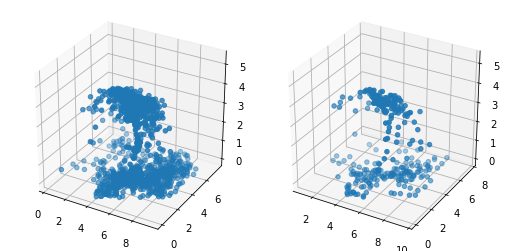

Mean train activation: 3.6506271
Mean train activation: 3.5708144


In [31]:
z_param_train = E.predict(x_train)
z_param_test = E.predict(x_test)
#print(z_param)

fig = plt.figure(figsize=1.8/2*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(z_param_train[:,0],z_param_train[:,1],z_param_train[:,2])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(z_param_test[:,0],z_param_test[:,1],z_param_test[:,2])

plt.tight_layout()
plt.show()

print('Mean train activation: '+str(z_param_train.mean()))
print('Mean train activation: '+str(z_param_test.mean()))

# Analyzing Deep Auto-encoders

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00100: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00079: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00126: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00074: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00151: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00116: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00166: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00106: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00126: early stopping
[0.0433, 0.0482, 0.043, 0.0641, 0.0328, 0.0402, 0

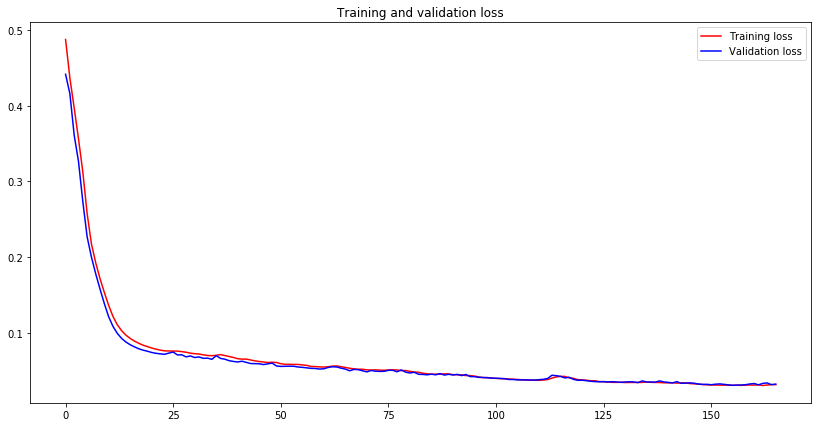

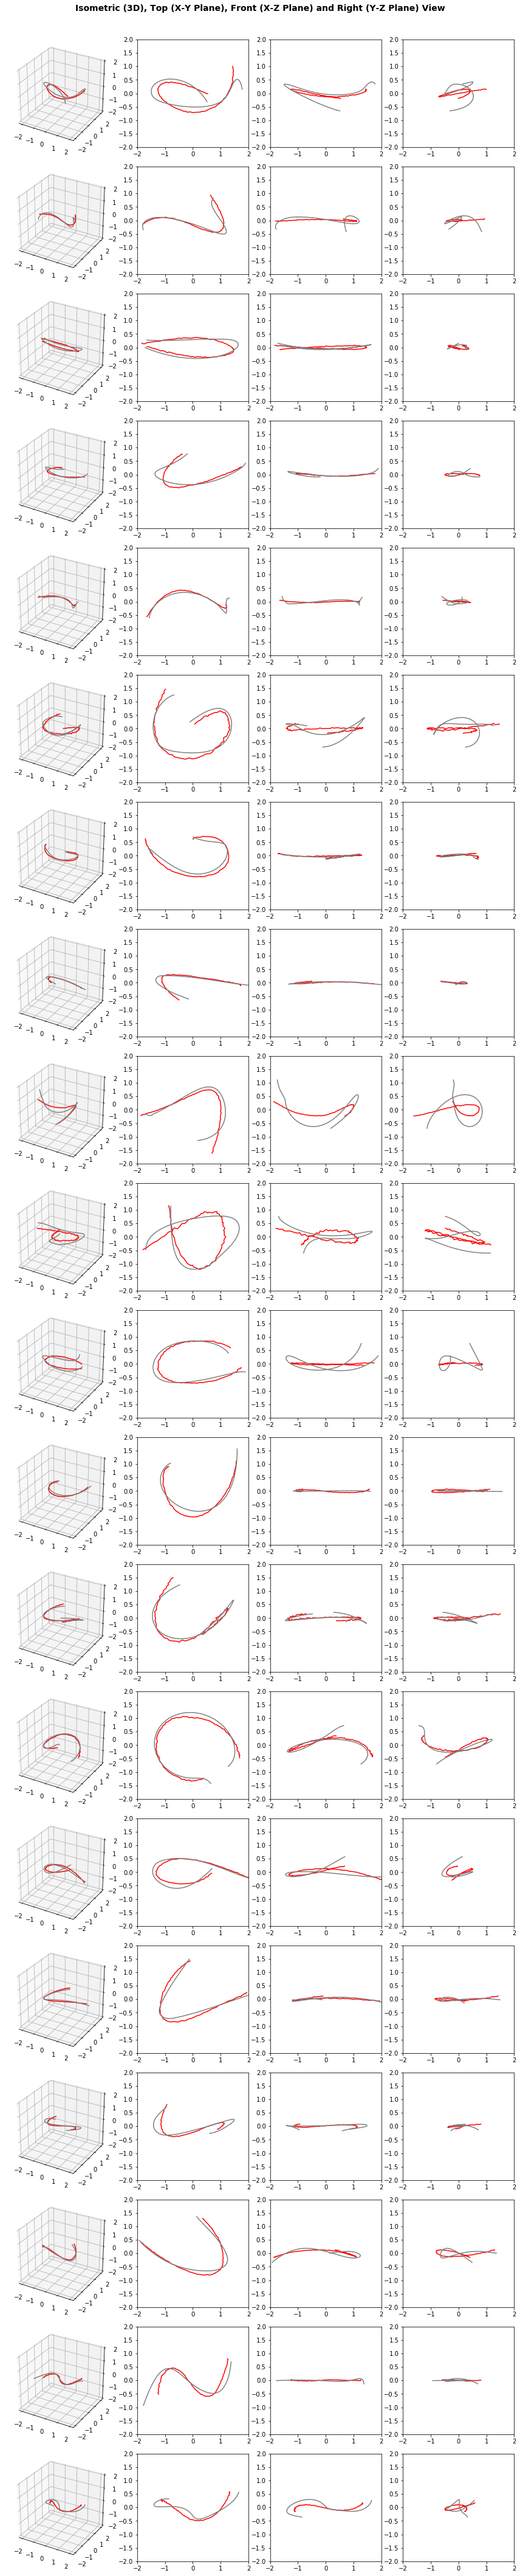

In [24]:
def autoEncoderRZ30_Thin():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ30_Thin, 10, x_train, x_test, filename='RZ30_Thin')
visualize_AE(AE, train_data, x_test)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00066: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00086: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00127: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00143: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00128: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00103: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00106: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00134: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00113: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00079: early stopping
[0.0145, 0.011, 0.0085, 0.0087, 0.0107, 0.0133, 0

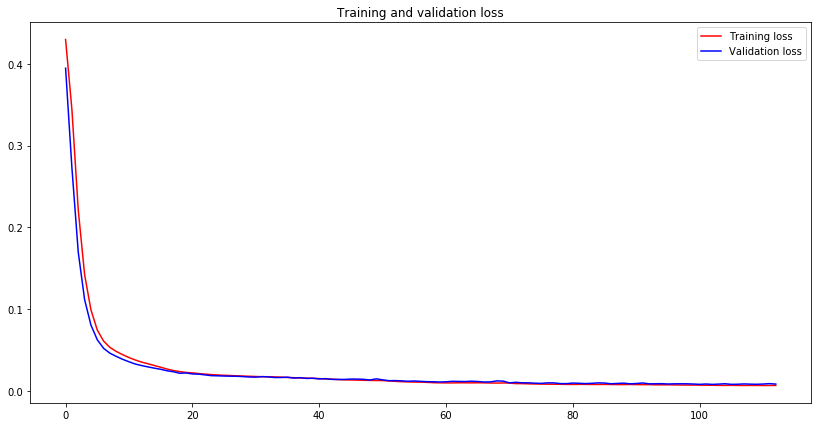

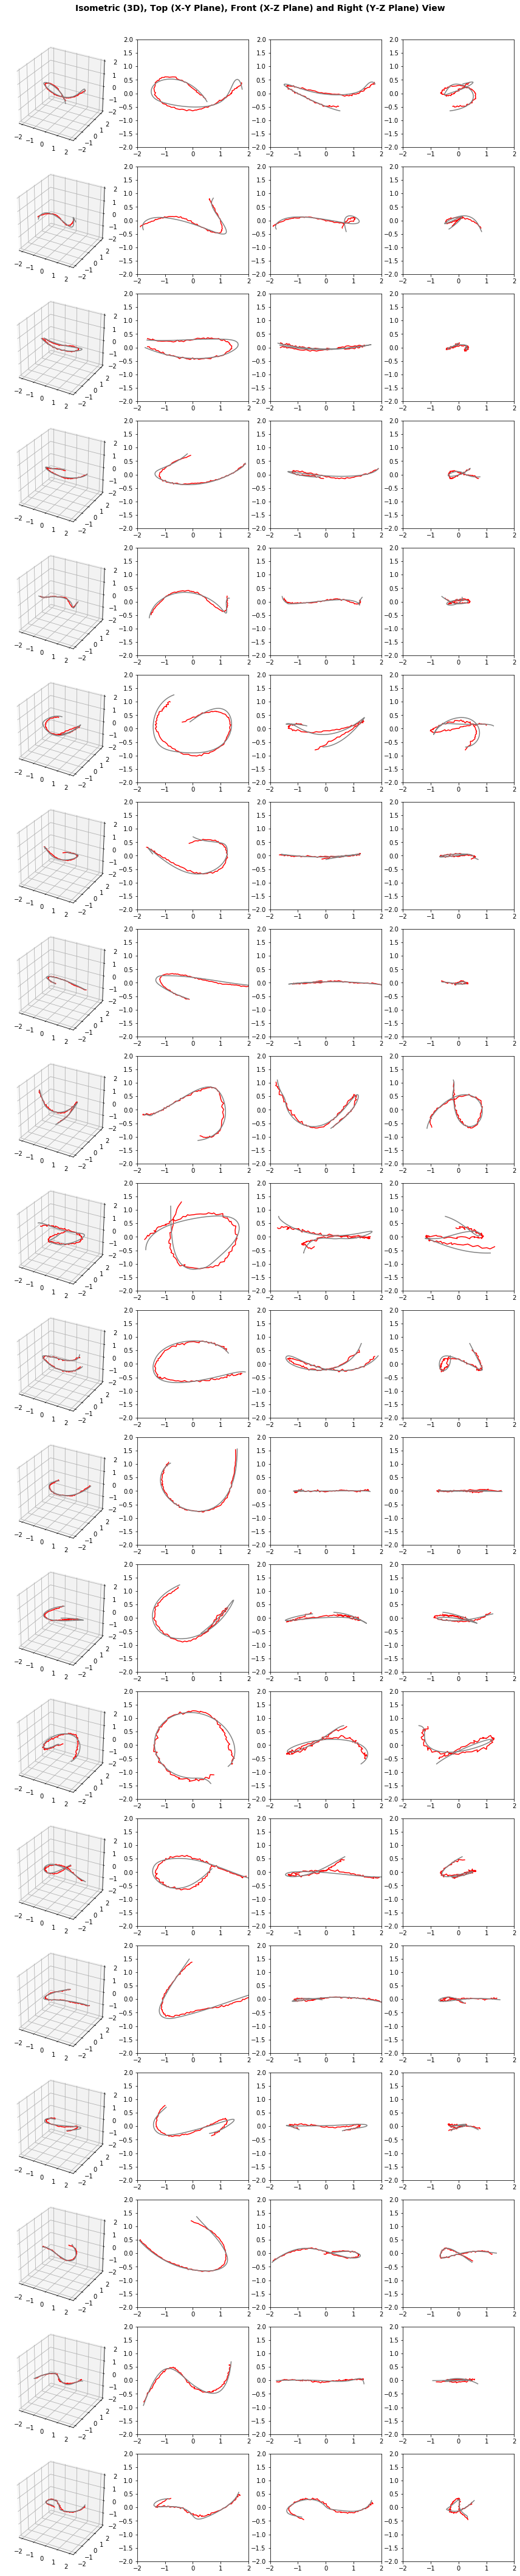

In [28]:
def autoEncoderRZ30_Thick():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(60, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ30_Thick, 10, x_train, x_test, filename='RZ30_Thick')
visualize_AE(AE, train_data, x_test)

## Visualize variation of coupler curves with change in z-space parameters

# 3. Convolutional Autoencoders

## Convolution (Normal) AutoEncoder Z=15, 30 

Inspired to capture global convolutional features of curves like the Fourier coefficients

In [ ]:
from keras.layers import Conv2D, Conv1D

def autoEncoderCovZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x = Conv1D(15, (100), activation='relu')(inp_curve)
    x=Flatten()(x)
    encoded=Dense(3, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(20, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderCovZ3, 10, x_train, x_test, filename='CovZ3')
AE.summary()
visualize_AE(AE, train_data, x_test)

## Convolution (Spatial Separable) AutoEncoder Z=15, 30

Inspired to capture local convolutional features of curves like the Wavelet coefficients

In [ ]:
from keras.layers import Lambda, Add, MaxPooling1D, UpSampling1D

def autoEncoderCov1DZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x1=SeparableConv1D(4,5,padding='same')(inp_curve)
    x1=MaxPooling1D(2)(x1)
    x1=Flatten()(x1)
    x2=SeparableConv1D(4,20,padding='same')(inp_curve)
    x2=MaxPooling1D(2)(x2)
    x2=Flatten()(x2)
    x3=SeparableConv1D(4,50,padding='same')(inp_curve)
    x3=MaxPooling1D(2)(x3)
    x3=Flatten()(x3)
    x=concatenate([x1,x2,x3], axis=1)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    encoded=Dense(10, activation='relu')(x)

    # Decoding
    x=Dense(30, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(600, activation='relu')(x)
    x1=Lambda(lambda x: x[:,0:50*4])(x)
    x1=UpSampling1D(2)(x1)
    x1=Reshape((100, 4))(x1)
    x1=SeparableConv1D(4,5,padding='same')(x1)
    x2=Lambda(lambda x: x[:,50*4:2*50*4])(x)
    x2=UpSampling1D(2)(x2)
    x2=Reshape((100, 4))(x2)
    x2=SeparableConv1D(4,5,padding='same')(x2)
    x3=Lambda(lambda x: x[:,2*50*4:3*50*4])(x)
    x3=UpSampling1D(2)(x3)
    x3=Reshape((100, 4))(x3)
    x3=SeparableConv1D(4,5,padding='same')(x3)
    x=Add()([x1, x2, x3])
    decoded=SeparableConv1D(3,5,padding='same')(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

AE,E,train_data =AE_analysis(autoEncoderCov1DZ10, 10, x_train, x_test, filename='Z10C1D')
visualize_AE(AE, train_data, x_test)

## Convolution (with FFT) AutoEncoder Z=15, 30

## Variational Autoencoder Z=3,15, 30